This notebook includes the whole precedure building a binary classifier model, including:
### Step 1: Loading the preprocessed dataset
### Step 2: Split into training and testing datasets and normalize features
  - To avoid the individual bias and avoid the feature leakage, we randomly split videos into the training(80%) and testing dataset(20%)
  - We shuffle and randomly split the videos until the percentage of the paired investigation is comparable in both datasets
- To avoid order bias, we shuffle all investigation bouts within each dataset
- To avoid scaling bias, we apply Min-Max normalization on the training set and use the same transformation on the test set

### Step 3: Model selection and evaluation
- Logistic Regression & RandomForest
- Hyperopt for hyperparameters tuning
  - Loss function: - Matthew Correlation Coefficient(MCC)
  - Additional metrics: Accuracy score, F1 score

### Step 4: Interpreting the results
- SHAP(SHapley Additive exPlanations)

---
### Step 1: Loading the preprocessed dataset

| Loading modules 

In [1]:
#import the neccessary python packages for data manipulation
import numpy as np
np.random.seed(7) #set the seed globally for reproducity

import pandas as pd
import scipy as sp


#import packages for visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
import graphviz
from sklearn.tree import plot_tree


#import some useful functions from sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay, matthews_corrcoef
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

#for model hyperparameters selection
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


#for model interpretation
import shap #for feature importance


#statistic comparison method
#because in our dataset, paired and non-paired investigations might be from the same video sequence, 
#we use the mixed effects model to do the statistic test in these two groups, using sequence_code as a fixed effect
import statsmodels.formula.api as smf
from scipy.stats import ks_2samp

c:\Users\sky\anaconda3\envs\waffles\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random_state =7 #we set a global random state for reproducibility

### Step 1: Loading the preprocessed dataset


1 | Load the preprocessed data with hand-crafted features

,sequence,investigation_ID,pair_label,paired,start_frame,end_frame,duration,mean_speed,mean_acc,mean_rotation,mean_rotation_speed
0,task1/train/mouse001_task1_annotator1,0,0_0,0,1,126,126,6.619949,3.681024,2.861946,0.047836
1,task1/train/mouse001_task1_annotator1,1,1_0,0,136,633,498,6.364444,3.583990,2.924218,0.041316
2,task1/train/mouse001_task1_annotator1,2,2_0,0,659,714,56,9.422267,5.151395,2.938320,0.045286
3,task1/train/mouse001_task1_annotator1,3,3_0,0,736,898,163,4.820933,3.456058,3.002670,0.039957
4,task1/train/mouse001_task1_annotator1,4,4_0,0,944,1045,102,2.838757,2.808712,2.714141,0.036523


,investigation_ID,paired,start_frame,end_frame,duration,mean_speed,mean_acc,mean_rotation,mean_rotation_speed
count,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000
mean,29.082668,0.138590,6273.171587,6344.380688,72.209100,7.162941,4.765183,2.899996,0.053228
std,28.126639,0.345578,5144.694386,5132.128523,121.178995,4.923105,5.019670,0.134659,0.034554
min,0.000000,0.000000,1.000000,3.000000,1.000000,0.000000,0.000000,2.020127,0.000000
25%,8.000000,0.000000,2023.000000,2089.000000,14.000000,4.040029,3.032544,2.841902,0.035343
50%,20.000000,0.000000,4972.000000,5037.000000,30.000000,6.041922,4.023517,2.925928,0.046019
75%,42.000000,0.000000,9629.500000,9698.500000,71.500000,8.935472,5.381169,2.994524,0.060868
max,155.000000,1.000000,23128.000000,23176.000000,1335.000000,110.985818,218.968631,3.136071,0.737952


sequence               0
investigation_ID       0
pair_label             0
paired                 0
start_frame            0
end_frame              0
duration               0
mean_speed             0
mean_acc               0
mean_rotation          0
mean_rotation_speed    0
dtype: int64


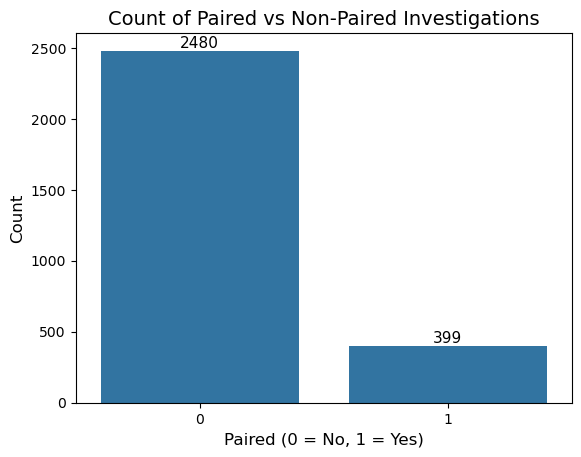

In [3]:
# Load your dataset (adjust path as needed)
df = pd.read_csv(r"G:\My Drive\100-PhD Study\110-Courses\2025Summer_Neuromatch\waffles\Waffle\preprocessed_data\final_df.csv")  # or df = your_dataframe

# Preview data
display(df.head())

# Summary statistics
display(df.describe())

# Check for missing values, just to make sure there's no missing data
print(df.isnull().sum())

# Show a bar plot reflecting the total number of 'paired investigation(1)' VS 'unpaired investigation(0)'
sns.countplot(data=df, x='paired')  
plt.title("Count of Paired vs Non-Paired Investigations", fontsize=14)
plt.xlabel("Paired (0 = No, 1 = Yes)", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Annotate the bars with counts
counts = df['paired'].value_counts().sort_index()
for i, count in enumerate(counts):
    plt.text(i, count + 2, str(count), ha='center', va='bottom', fontsize=11)

plt.show()




##### We extracted 2879 investigation bouts from 88 videos, and (399/2879)13.9% of them are paired with a followed attack, which means the this is an imbalanced dataset with most investigations not immediately followed by an attack.

### Step 2: Split into training and testing datasets
1. GroupShuffleSplit the videos into the training(80%) and testing(20%) 
2. Shuffle the investigation bouts within a trianing set to avoid the order bias

In [4]:
print("Number of unique sequences:", df['sequence'].unique())
#note that 'task1/train/mouse036_task1_annotator1' was dropped after runnning find_I_A_all function the the preprecessed_label_feature notebook

Number of unique sequences: ['task1/train/mouse001_task1_annotator1'
 'task1/train/mouse002_task1_annotator1'
 'task1/train/mouse003_task1_annotator1'
 'task1/train/mouse004_task1_annotator1'
 'task1/train/mouse005_task1_annotator1'
 'task1/train/mouse006_task1_annotator1'
 'task1/train/mouse007_task1_annotator1'
 'task1/train/mouse008_task1_annotator1'
 'task1/train/mouse009_task1_annotator1'
 'task1/train/mouse010_task1_annotator1'
 'task1/train/mouse011_task1_annotator1'
 'task1/train/mouse012_task1_annotator1'
 'task1/train/mouse013_task1_annotator1'
 'task1/train/mouse014_task1_annotator1'
 'task1/train/mouse015_task1_annotator1'
 'task1/train/mouse016_task1_annotator1'
 'task1/train/mouse017_task1_annotator1'
 'task1/train/mouse018_task1_annotator1'
 'task1/train/mouse019_task1_annotator1'
 'task1/train/mouse020_task1_annotator1'
 'task1/train/mouse021_task1_annotator1'
 'task1/train/mouse022_task1_annotator1'
 'task1/train/mouse023_task1_annotator1'
 'task1/train/mouse024_task1_

In [5]:
#reencode the video ID to numbers
# Encode 'sequence' into numeric form 
df['sequence_code'] = pd.factorize(df['sequence'])[0]  # or 'video_id'


In [6]:
#drop the non-numeric information
non_numeric =['sequence', 'pair_label','start_frame','end_frame']
df_dropped = df.copy(deep=True)
df_dropped = df_dropped.drop(columns=non_numeric)

In [7]:
df_dropped

,investigation_ID,paired,duration,mean_speed,mean_acc,mean_rotation,mean_rotation_speed,sequence_code
0,0,0,126,6.619949,3.681024,2.861946,0.047836,0
1,1,0,498,6.364444,3.583990,2.924218,0.041316,0
2,2,0,56,9.422267,5.151395,2.938320,0.045286,0
3,3,0,163,4.820933,3.456058,3.002670,0.039957,0
4,4,0,102,2.838757,2.808712,2.714141,0.036523,0
...,...,...,...,...,...,...,...,...
2874,42,0,6,2.615893,3.908312,3.126484,0.009456,87
2875,43,0,8,3.931406,2.945635,2.808574,0.045937,87
2876,44,0,13,1.449746,1.718144,2.936758,0.031133,87
2877,45,0,144,2.105103,2.130460,3.040754,0.018255,87


In [8]:
#twrite a function to split the dataset until the bouts and paired investigation percentage is similar in the trainig and testing dataset
best_diff = float('inf')
best_split = None

#use video sequence as a group ID  for group shuffle, so each video sequence is an unit in shuffling
groups = df_dropped['sequence_code']   
labels = df_dropped['paired'].values

#search for a seed that result a comparable percentage of paired investigation in both datasets
for seed in range(1000):
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=seed) #group shuffle split by the video sequence
    train_idx, test_idx = next(gss.split(df_dropped, labels, groups=groups))
    
    y_train = labels[train_idx]
    y_test = labels[test_idx]
    
    train_pct = y_train.mean()
    test_pct = y_test.mean()
    
    diff = abs(train_pct - test_pct)
    
    if diff < best_diff:
        best_diff = diff
        best_split = (train_idx, test_idx)
        
    if diff < 0.01:  # stop early if sufficiently close
        break

train_idx, test_idx = best_split
df_train = df_dropped.iloc[train_idx].reset_index(drop=True)
df_test = df_dropped.iloc[test_idx].reset_index(drop=True)


In [9]:
print("random seed is: ",seed)

random seed is:  7


### | Shuffle the investigation bouts within each dataset

In [10]:
#shuffle bouts in trianig set to avoid the order bias
df_train = df_train.sample(frac=1, random_state=random_state).reset_index()
x_train = df_train.drop(columns=['paired'])
y_train = df_train['paired']
#same shuffle in the testing dataset to void the order bias
df_test = df_test.sample(frac=1,random_state=random_state).reset_index()
x_test = df_test.drop(columns=['paired'])
y_test = df_test['paired']

### | Sanity check of the splitted training and testing dataset

1. check if the counts of the investigations from the same video are comparable

In [11]:
#show the counts of investigations from the same vdeo is comparable
x_train_counts = x_train.groupby('sequence_code').count()
x_test_counts = x_test.groupby('sequence_code').count() 

In [12]:
x_train_counts

,index,investigation_ID,duration,mean_speed,mean_acc,mean_rotation,mean_rotation_speed
sequence_code,,,,,,,
0,58,58,58,58,58,58,58
1,123,123,123,123,123,123,123
3,22,22,22,22,22,22,22
4,15,15,15,15,15,15,15
5,14,14,14,14,14,14,14
...,...,...,...,...,...,...,...
83,47,47,47,47,47,47,47
84,20,20,20,20,20,20,20
85,39,39,39,39,39,39,39


| Visualize the distribution of counts of investigation from the same video
- We expect to see a similar distribution, which indicates we are not splitting videos with an investigation counts bias

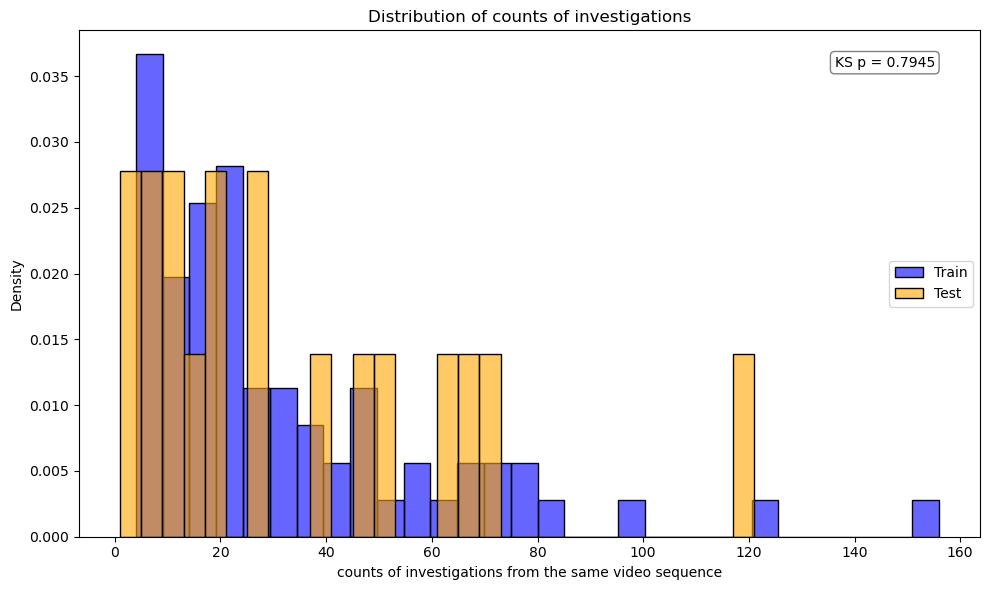

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(x_train_counts['investigation_ID'], color='blue', label='Train', bins=30, kde=False, stat='density', alpha=0.6)
sns.histplot(x_test_counts['investigation_ID'], color='orange', label='Test', bins=30, kde=False, stat='density', alpha=0.6)

# KS test
ks_stat, ks_p = ks_2samp(x_train_counts['investigation_ID'], x_test_counts['investigation_ID'])

# Annotate
plt.text(0.95, 0.95, f"KS p = {ks_p:.4f}", transform=plt.gca().transAxes,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray"))

plt.title("Distribution of counts of investigations")
plt.xlabel("counts of investigations from the same video sequence")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


Another way to show this is to compare the distribution of 'investigation_ID' , we expect to see a similar distribution if videos from training and testing dataset have similar amount of investigations  

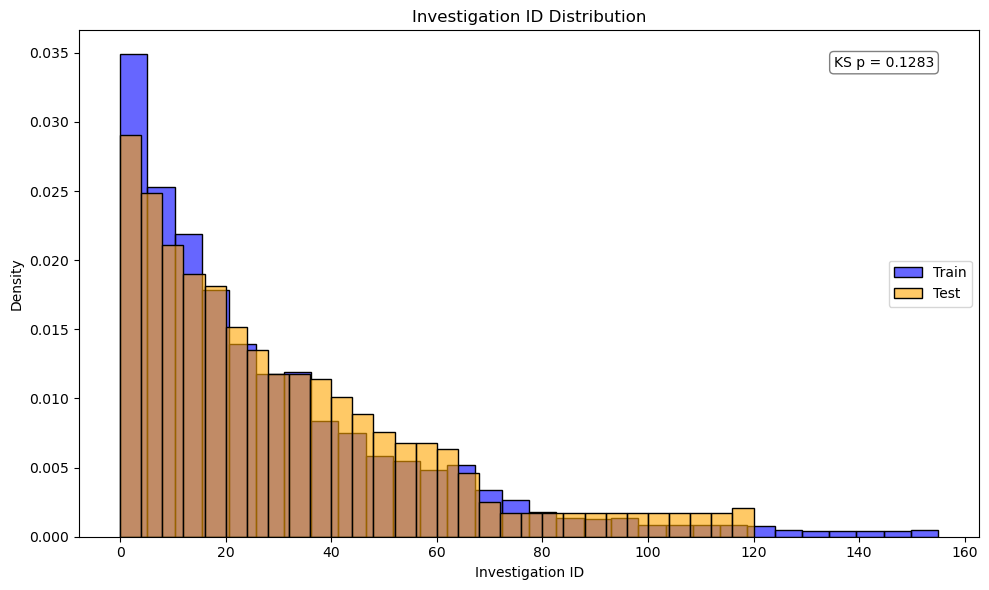

In [14]:
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_train['investigation_ID'], color='blue', label='Train', bins=30, kde=False, stat='density', alpha=0.6)
sns.histplot(df_test['investigation_ID'], color='orange', label='Test', bins=30, kde=False, stat='density', alpha=0.6)

# KS test
ks_stat, ks_p = ks_2samp(df_train['investigation_ID'], df_test['investigation_ID'])

# Annotate
plt.text(0.95, 0.95, f"KS p = {ks_p:.4f}", transform=plt.gca().transAxes,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray"))

plt.title("Investigation ID Distribution")
plt.xlabel("Investigation ID")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


2. check if ther percentage of paired investigations are comparable 

C:\Users\sky\AppData\Local\Temp\ipykernel_37800\824523022.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Train', 'Test'], y=bouts_vals, palette=colors, ax=ax[0])
C:\Users\sky\AppData\Local\Temp\ipykernel_37800\824523022.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Train', 'Test'], y=paired_pct_vals, palette=colors, ax=ax[1])


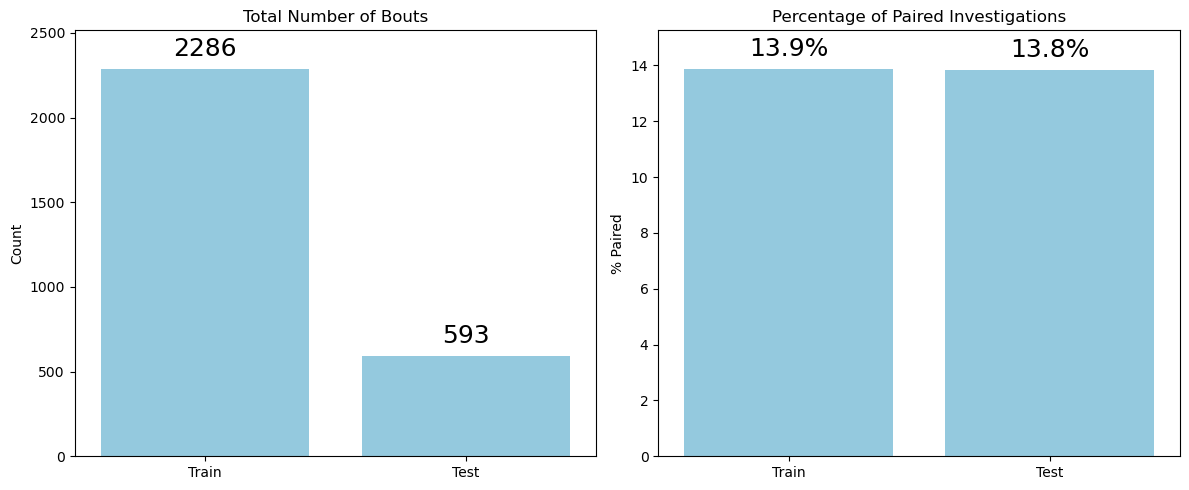

In [15]:

# Data
n_train = len(df_train)
n_test = len(df_test)

train_paired = df_train['paired'].sum()
test_paired = df_test['paired'].sum()

train_paired_pct = train_paired / n_train * 100
test_paired_pct = test_paired / n_test * 100

# --- Plot ---
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
colors = ['skyblue', 'skyblue']

# 1. Total number of bouts
bouts_vals = [n_train, n_test]
sns.barplot(x=['Train', 'Test'], y=bouts_vals, palette=colors, ax=ax[0])
ax[0].set_title('Total Number of Bouts')
ax[0].set_ylabel('Count')

# Add value labels and adjust y-limit
max_bouts = max(bouts_vals)
for i, val in enumerate(bouts_vals):
    ax[0].text(i, val + max_bouts * 0.02, f'{val}', ha='center', va='bottom', fontsize=18)
ax[0].set_ylim(0, max_bouts * 1.10)

# 2. Percentage of paired investigations
paired_pct_vals = [train_paired_pct, test_paired_pct]
sns.barplot(x=['Train', 'Test'], y=paired_pct_vals, palette=colors, ax=ax[1])
ax[1].set_title('Percentage of Paired Investigations')
ax[1].set_ylabel('% Paired')

max_pct = max(paired_pct_vals)
for i, val in enumerate(paired_pct_vals):
    ax[1].text(i, val + max_pct * 0.02, f'{val:.1f}%', ha='center', va='bottom', fontsize=18)
ax[1].set_ylim(0, max_pct * 1.10)

plt.tight_layout()
plt.show()


3. check whether the correlation between each features are similar in training and testing dataset

In [16]:
features = ["duration","mean_speed","mean_acc","mean_rotation","mean_rotation_speed"]
x_train_corr = x_train[features].corr(numeric_only=True)
x_test_corr = x_test[features].corr(numeric_only=True)

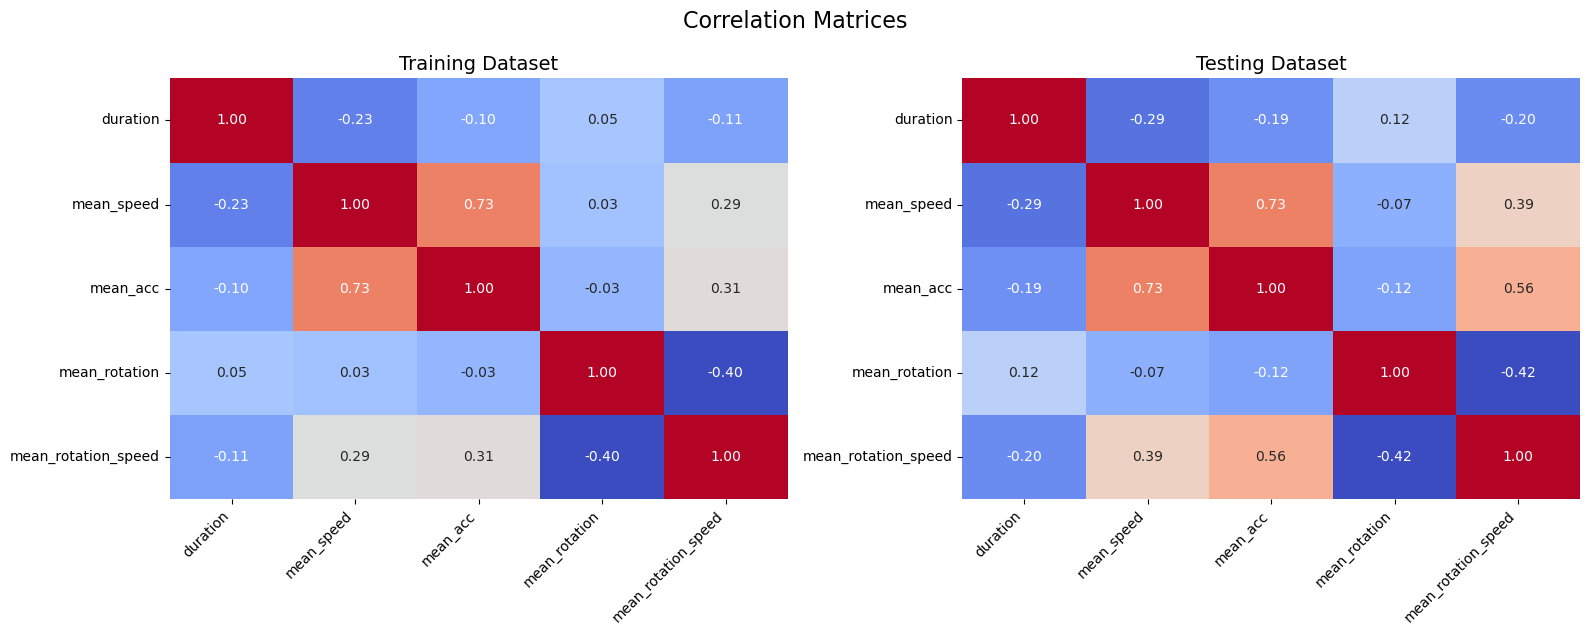

In [17]:

plt.figure(figsize=(16, 6))  # Wider figure for better spacing

# Training set correlation matrix
plt.subplot(1, 2, 1)
sns.heatmap(x_train_corr, annot=True, cmap='coolwarm', fmt=".2f", 
            cbar=False, annot_kws={"size": 10})
plt.title("Training Dataset", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Testing set correlation matrix
plt.subplot(1, 2, 2)
sns.heatmap(x_test_corr, annot=True, cmap='coolwarm', fmt=".2f", 
            cbar=False, annot_kws={"size": 10})
plt.title("Testing Dataset", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.suptitle("Correlation Matrices", fontsize=16, y=1.05)
plt.show()


combined with the correlation calculation, we found that in both dataset, mean speed and mean acceleration has 0.73 correlation


### | (Exploration)Are the handcrafted features are significantly different between the paired investigation VS non-paired investigation?
- Consider the mixed effect models, since the investigations from the same video might have their own bias

In [18]:
#merge the traininig dataset with label for violin plotting
x_train_violin = x_train.copy(deep=True)
x_train_violin["paired"] = y_train.values
x_test_violin = x_test.copy(deep=True)
x_test_violin["paired"] = y_test.values

#do the 

#violin plot for features by paired investigation VS non-paired investigation
features = ["duration","mean_speed","mean_acc","mean_rotation","mean_rotation_speed"]

| Check whether features are significantly different in paired VS non-paired investigations, and check whether the trend is preserved in both the training and testing datasets

In [19]:
#do the mixed effect test
mixed_results = {}
for feature in features:
    model_df = x_train_violin[[feature,'paired','sequence_code']].dropna()
    model_df['paired'] = model_df['paired'].astype('category')
    
    try:
        model = smf.mixedlm(f"{feature}~paired", model_df, groups=model_df["sequence_code"])
        result = model.fit()
        #T.1 mean "this is the treatment level corresponding to paired=1", so we view non-paired as the reference or basline
        pval = result.pvalues.get('paired[T.1]',None) #extract p for paired=1
        mixed_results[feature] = {
            'model':'feature ~ paired + (1 | sequence_code)',
            'pval':pval
        }
    except Exception as e:
        print(f'Could not fit model for {feature}: {e}')
        mixed_results[feature]={
            'model':'model failed',
            'pval': None
        }

c:\Users\sky\anaconda3\envs\waffles\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sky\anaconda3\envs\waffles\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


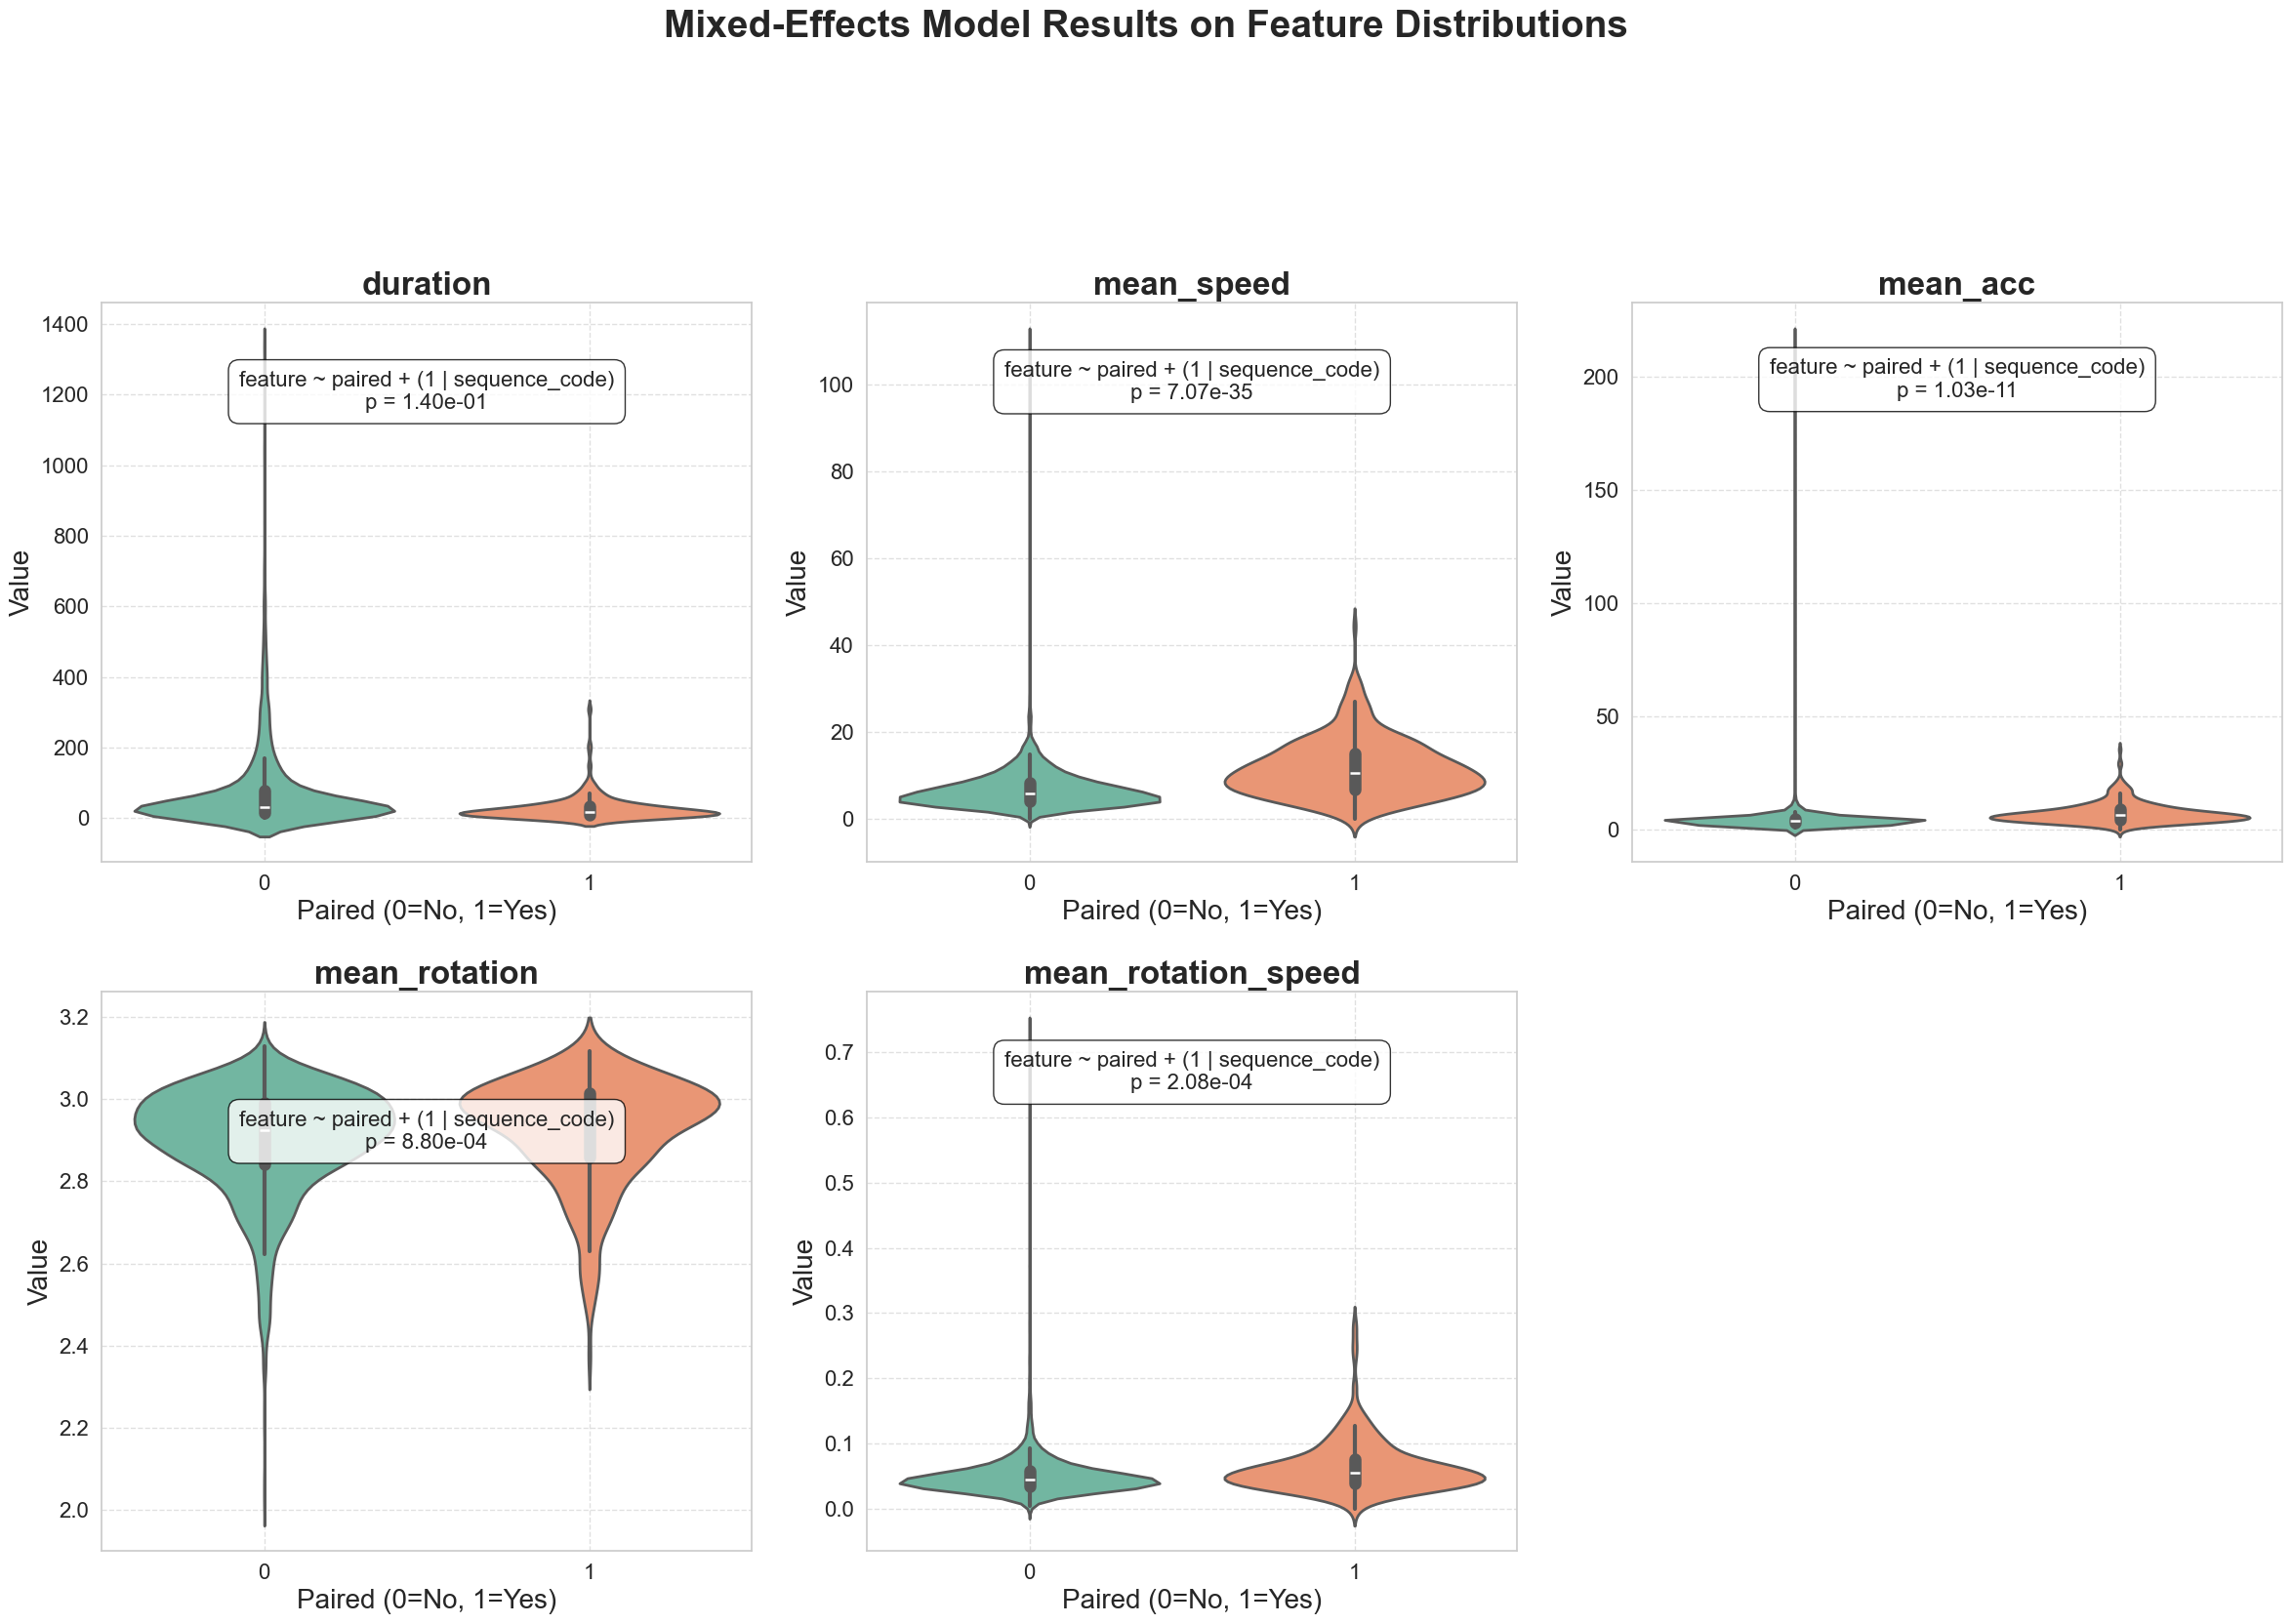

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set global style and font scale for big presentations
sns.set(style="whitegrid", font_scale=2)

# Initialize figure with large size
plt.figure(figsize=(24, 16))

for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)

    # Draw violin plot with hue to avoid deprecation warning
    sns.violinplot(
        data=x_train_violin,
        x='paired',
        y=feature,
        hue='paired',
        palette='Set2',
        density_norm='width',
        inner='box',
        linewidth=2,
        legend=False
    )

    # Set titles and labels in large fonts
    plt.title(f'{feature}', fontsize=24, fontweight='bold')
    plt.xlabel('Paired (0=No, 1=Yes)', fontsize=20)
    plt.ylabel('Value', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Add model annotation with larger font
    model_info = mixed_results.get(feature, {})
    model_text = model_info.get('model', 'model failed')
    pval = model_info.get('pval', None)
    annotation = f'{model_text}\np = {pval:.2e}' if pval is not None else f'{model_text}\np = N/A'

    # Put annotation slightly above max y
    y_max = x_train_violin[feature].max()
    plt.text(
        0.5,
        y_max * 0.95,
        annotation,
        ha='center',
        va='top',
        fontsize=16,
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.8, boxstyle='round,pad=0.5')
    )

# Super title
plt.suptitle('Mixed-Effects Model Results on Feature Distributions', fontsize=28, fontweight='bold', y=1.05)

# Fix layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


- We can see that mean speed, mean acceleration, mean rotation angle, and mean rotation speed are significantly different between the paired investigations and non-paired investigations

### | (exploration)Can we see similar statistic difference in test dataset?

In [21]:
# do the same test for the test dataset
#do the mixed effect test
mixed_results = {}
for feature in features:
    model_df = x_test_violin[[feature,'paired','sequence_code']].dropna()
    model_df['paired'] = model_df['paired'].astype('category')
    
    try:
        model = smf.mixedlm(f"{feature}~paired", model_df, groups=model_df["sequence_code"])
        result = model.fit()
        #T.1 mean "this is the treatment level corresponding to paired=1", so we view non-paired as the reference or basline
        pval = result.pvalues.get('paired[T.1]',None) #extract p for paired=1
        mixed_results[feature] = {
            'model':'feature ~ paired + (1 | sequence_code)',
            'pval':pval
        }
    except Exception as e:
        print(f'Could not fit model for {feature}: {e}')
        mixed_results[feature]={
            'model':'model failed',
            'pval': None
        }

c:\Users\sky\anaconda3\envs\waffles\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\sky\anaconda3\envs\waffles\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\sky\anaconda3\envs\waffles\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\sky\anaconda3\envs\waffles\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
c:\Users\sky\anaconda3\envs\waffles\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check ml

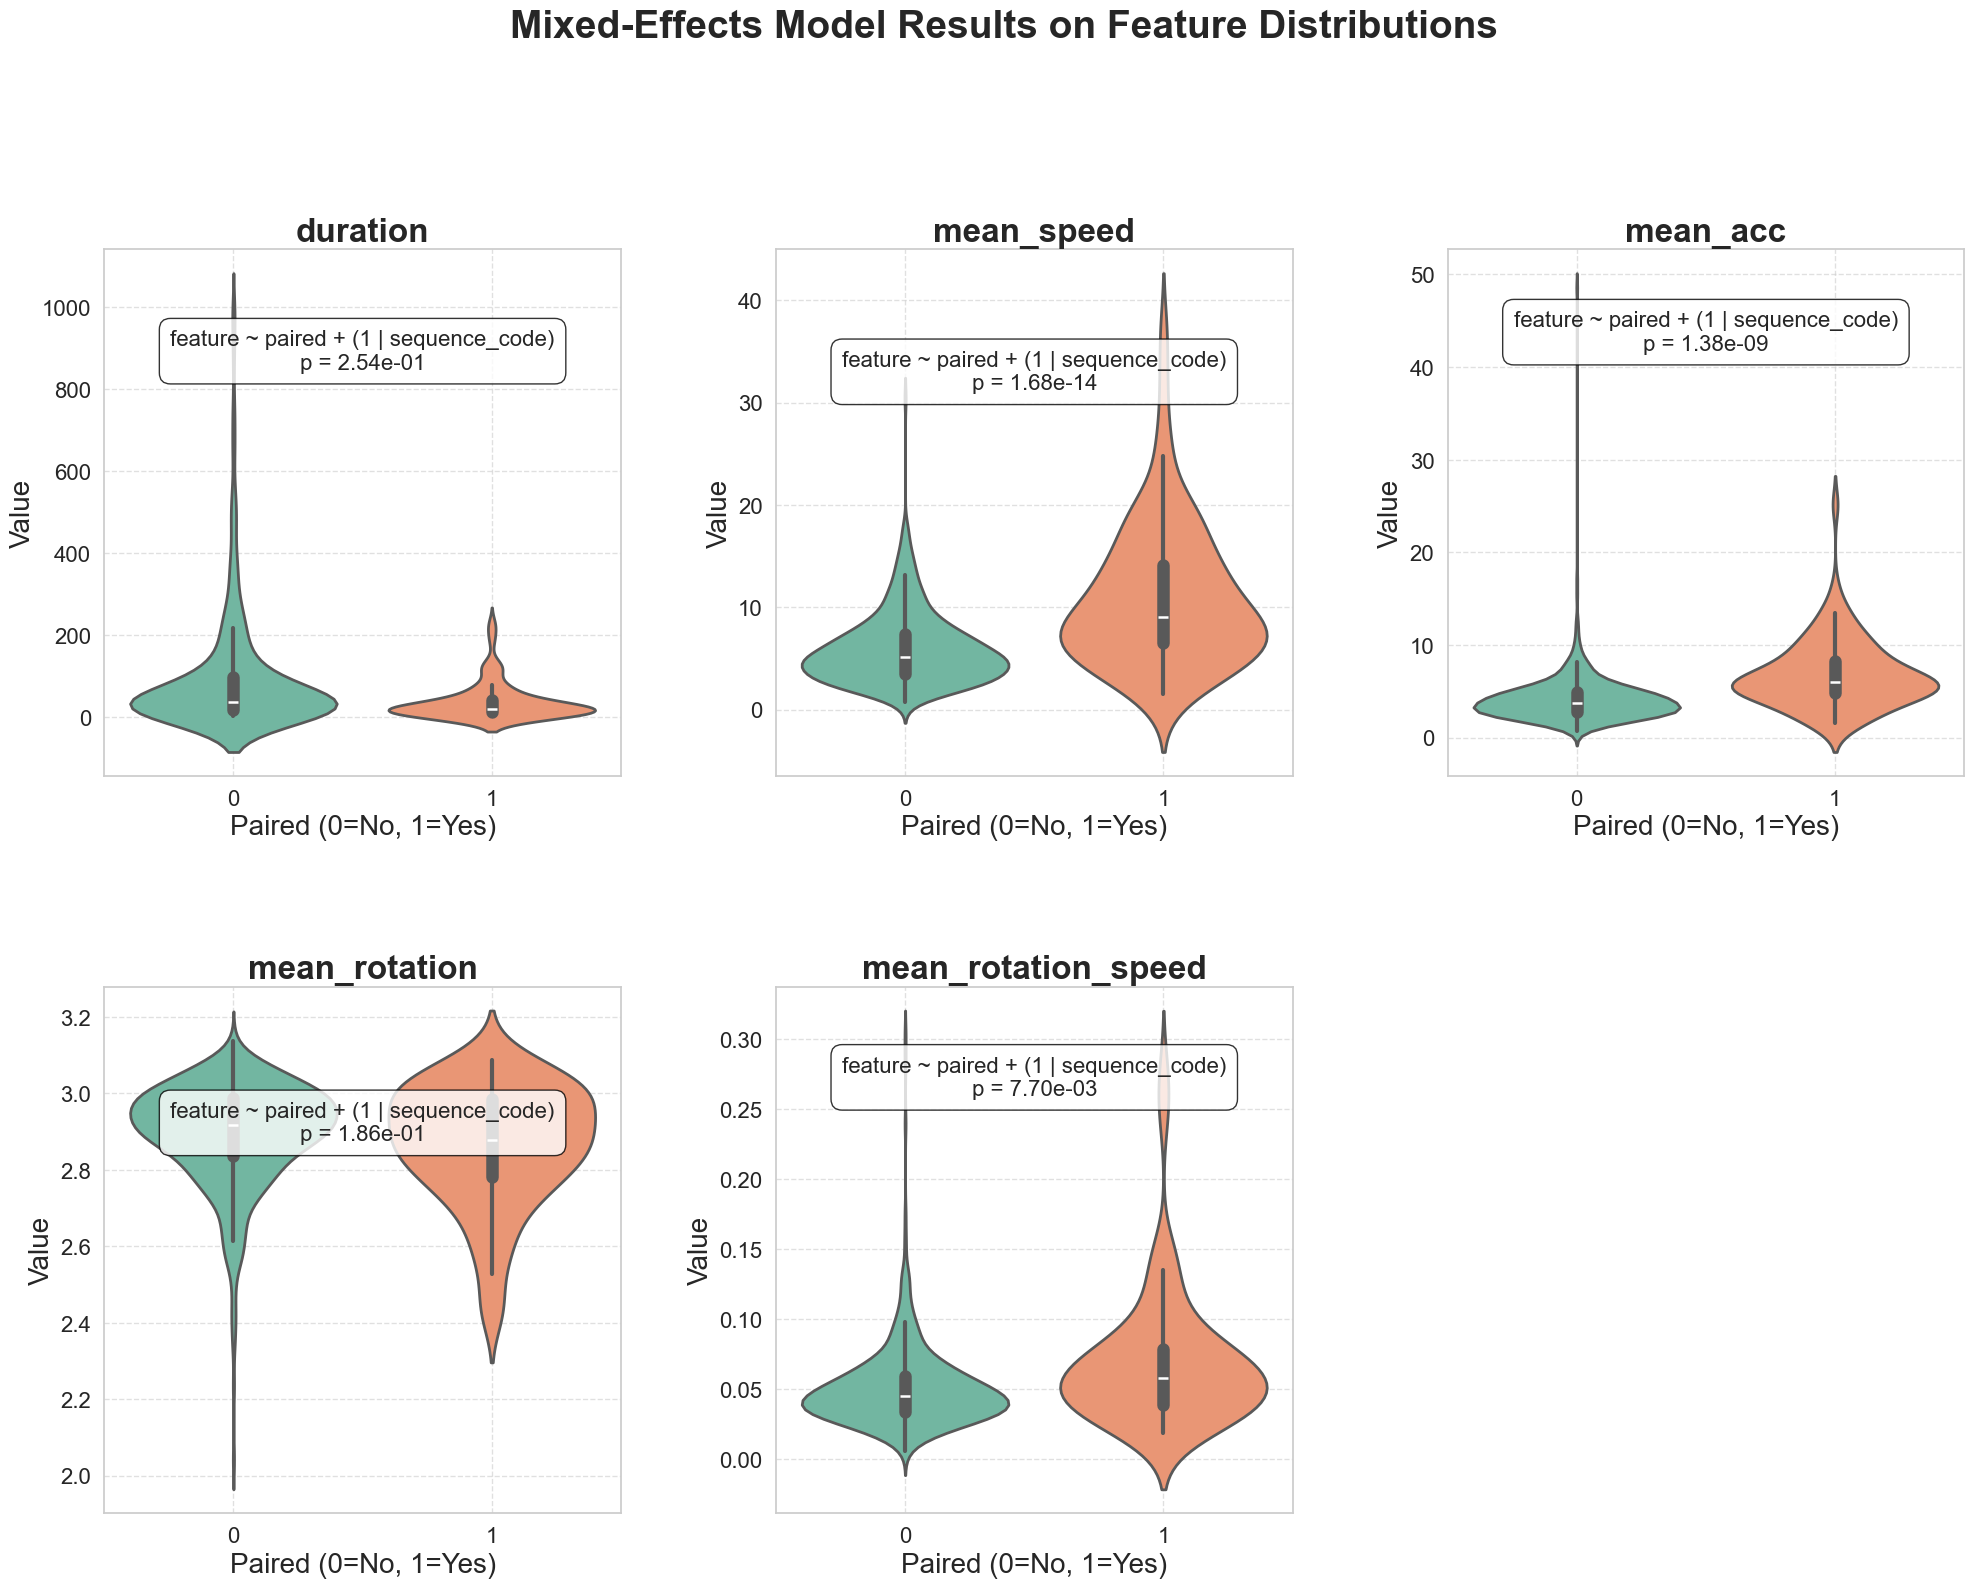

In [22]:

# Set global style and font scale for big presentations
sns.set(style="whitegrid", font_scale=2)

# Initialize figure with large size
plt.figure(figsize=(24, 16))

for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)

    # Draw violin plot with hue to avoid deprecation warning
    sns.violinplot(
        data=x_test_violin,
        x='paired',
        y=feature,
        hue='paired',
        palette='Set2',
        density_norm='width',
        inner='box',
        linewidth=2,
        legend=False
    )

    # Set titles and labels in large fonts
    plt.title(f'{feature}', fontsize=24, fontweight='bold')
    plt.xlabel('Paired (0=No, 1=Yes)', fontsize=20)
    plt.ylabel('Value', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Add model annotation with larger font
    model_info = mixed_results.get(feature, {})
    model_text = model_info.get('model', 'model failed')
    pval = model_info.get('pval', None)
    annotation = f'{model_text}\np = {pval:.2e}' if pval is not None else f'{model_text}\np = N/A'

    # Put annotation slightly above max y
    y_max = x_test_violin[feature].max()
    plt.text(
        0.5,
        y_max * 0.95,
        annotation,
        ha='center',
        va='top',
        fontsize=16,
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.8, boxstyle='round,pad=0.5')
    )

# Super title
plt.suptitle('Mixed-Effects Model Results on Feature Distributions', fontsize=28, fontweight='bold', y=1.05)

# Fix layout
plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3)

plt.show()


- From the mixed effect model, the mean rotation angle is not significantly different, so we expect to see a decrease of prediction accuracy if the model relys heavily on the mean rotation

### | Apply MinMaxScaler to normalize the features

In [23]:
#normalize the features to avoid the learned weight bias
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test) #remember to fit the same transformation to the test datset

In [24]:
# Convert back to DataFrames
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns).reset_index(drop=True)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns).reset_index(drop=True)#drop the index column

### | (Exploration) Check the distribution and correlation of features

| plot the scatter_matrix to :
1. Visualize pairwise relationships between all features
2. Check correlations or patterns among features
3. Spot outliers or clusters
4. Use color (c) to reflect class labels, e.g. y_train

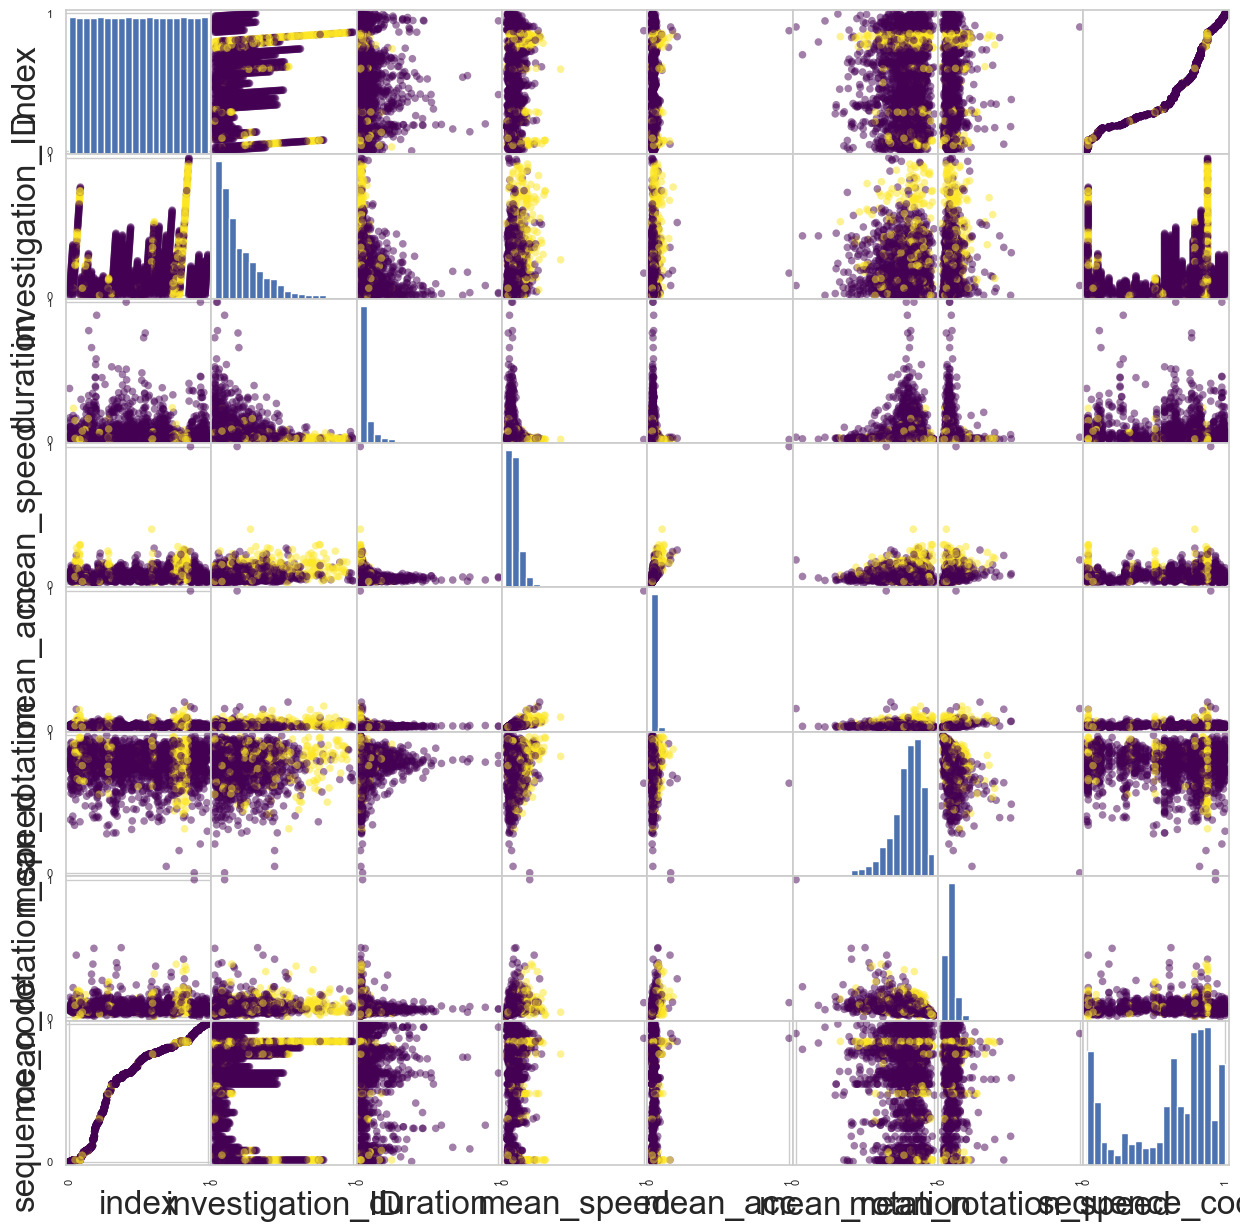

In [25]:
#check the correlation between each features, a good feature selection should avoid the correlation
import matplotlib.pyplot as plt
import pandas as pd

grr = pd.plotting.scatter_matrix(
    x_train_scaled,
    c=y_train,
    figsize=(15, 15),
    marker='o',
    hist_kwds={'bins': 20},
    s=30,
    alpha=0.5,
    diagonal='hist',
    cmap='viridis'  # or 'viridis', 'coolwarm', 'inferno', etc.
)


### Step 3: Model selection and evaluation

| before applying the model, drop the investigation_ID and sequence_code in the features column

In [26]:
#before applying the model, drop the investigation_ID and sequence_code
non_related = ['investigation_ID', 'sequence_code','index']
x_train_scaled_final = x_train_scaled.copy(deep=True)
x_test_scaled_final = x_test_scaled.copy(deep=True)
x_train_scaled_final = x_train_scaled_final.drop(columns = non_related)
x_test_scaled_final = x_test_scaled_final.drop(columns = non_related)

| Logistic regression
1. We starts Logistic regression(LR_unbalanced) without penalizing misclassifying the minority class more
   - L2 penalty
   - class_weights: None
   - Grid search C: 10^-4 - 10^4

In [27]:
#apply the logistic regression
# Logistic Regression with GridSearchCV
param_grid = {
    'C': np.logspace(-4, 4, 10),  # Inverse of regularization strength
    'penalty': ['l2'],
    'solver': ['lbfgs'],  # Suitable for L2, saga for l1
    'max_iter': [1000],
}

logreg_nonbalanced = LogisticRegression()

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state) #use this to preserve the percentages of paired or not paired samples are comparable

grid_search = GridSearchCV(logreg_nonbalanced, param_grid, cv=cv, scoring='matthews_corrcoef', n_jobs=-1, verbose=1)
grid_search.fit(x_train_scaled_final, y_train)

# Best model
best_model_nonbalanced = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'C': 10000.0, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


Test Accuracy: 0.8786
F1 Score: 0.2340
Matthews correcoefficient:  0.3241
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93       511
           1       0.92      0.13      0.23        82

    accuracy                           0.88       593
   macro avg       0.90      0.57      0.58       593
weighted avg       0.88      0.88      0.84       593



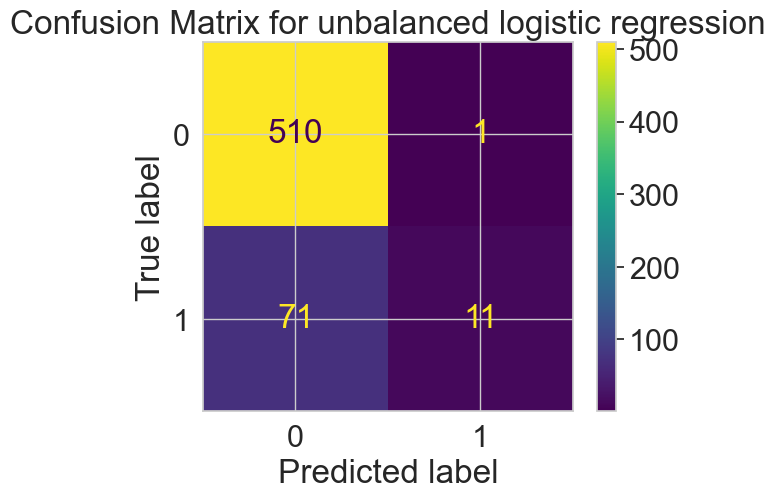

In [28]:
# Predict on test set
y_pred = best_model_nonbalanced.predict(x_test_scaled_final)

# Accuracy
acc_unbalanced = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc_unbalanced:.4f}")

# F1 Score
f1_unbalanced = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_unbalanced:.4f}")

mcc_unbalanced = matthews_corrcoef(y_test,y_pred)
print(f"Matthews correcoefficient: {mcc_unbalanced: .4f}")

# Full report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_model_nonbalanced, x_test_scaled_final, y_test)
plt.title("Confusion Matrix for unbalanced logistic regression")
plt.show()


2. Logistic regression with penalizing misclassifying the minority class more
   - L2 penalty:
   - set the class_weight to 'balanced': The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).
   - Grid Search C: 10^-4 - 10^4

In [29]:
#apply the logistic regression
# Logistic Regression with GridSearchCV
param_grid = {
    'C': np.logspace(-4, 4, 10),  # Inverse of regularization strength
    'penalty': ['l2'],
    'solver': ['lbfgs'],  # Suitable for L2, saga for l1
    'max_iter': [1000],
    'class_weight':['balanced'] #penalize misclassifying the minority class more
}

logreg_balanced = LogisticRegression()

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state) #use this to preserve the percentages of paired or not paired samples are comparable

grid_search = GridSearchCV(logreg_balanced, param_grid, cv=cv, scoring='matthews_corrcoef', n_jobs=-1, verbose=1)
grid_search.fit(x_train_scaled_final, y_train)

# Best model
best_model_balanced = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'C': 1291.5496650148827, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


Test Accuracy: 0.7622
F1 Score: 0.4051
Matthews correcoefficient:  0.2954
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.79      0.85       511
           1       0.31      0.59      0.41        82

    accuracy                           0.76       593
   macro avg       0.62      0.69      0.63       593
weighted avg       0.84      0.76      0.79       593



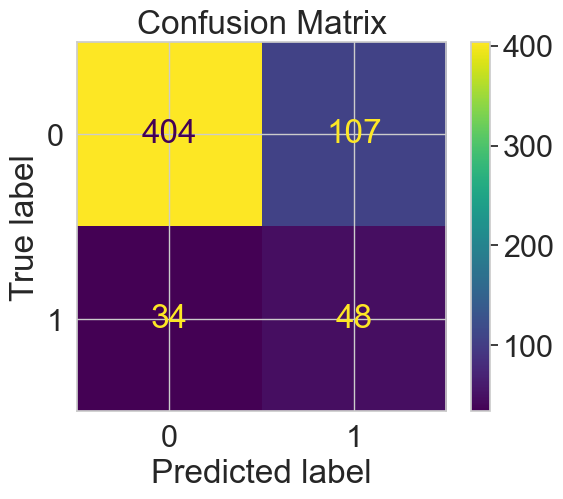

In [30]:
# Predict on test set
y_pred = best_model_balanced.predict(x_test_scaled_final)

# Accuracy
acc_balanced = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc_balanced:.4f}")

# F1 Score
f1_balanced = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_balanced:.4f}")

#matthews_corrcoef
mcc_balanced = matthews_corrcoef(y_test, y_pred)
print(f"Matthews correcoefficient: {mcc_balanced: .4f}")

# Full report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_model_balanced, x_test_scaled_final, y_test)
plt.title("Confusion Matrix")
plt.show()


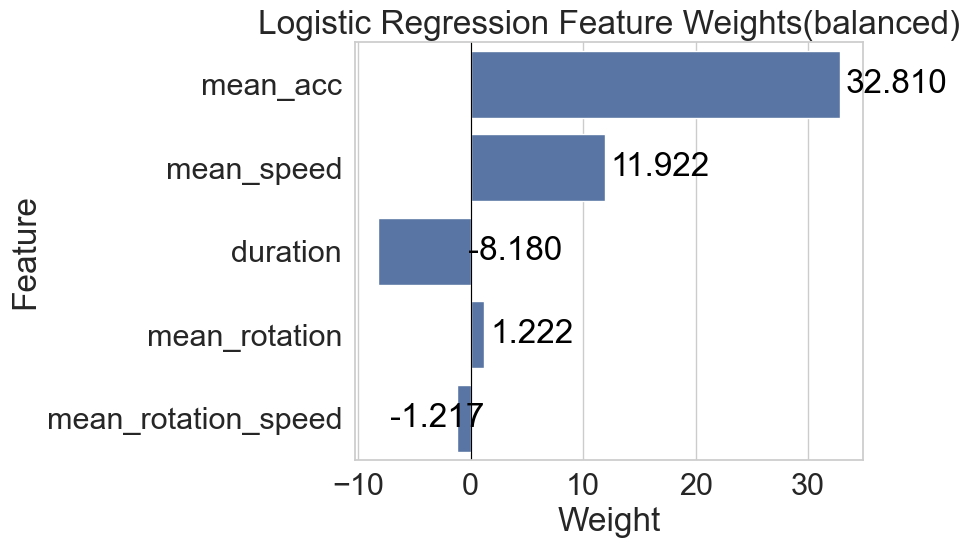

In [31]:
#visualize the coefficient

# Get feature names
feature_names = x_train_scaled_final.columns

# Get model coefficients (for binary classification, this is 1D)
coefs = best_model_balanced.coef_[0]

# Create a DataFrame for better plotting
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight': coefs
}).sort_values(by='Weight', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Weight', y='Feature', data=coef_df)
plt.axvline(0, color='black', linewidth=0.8)

for i, (weight, feature) in enumerate(zip(coef_df['Weight'], coef_df['Feature'])):
    if weight > 0:
        plt.text(weight + 0.5, i, f"{weight:.3f}", va='center', ha='left', color='black')
    else:
        plt.text(weight + 2 * abs(weight), i, f"{weight:.3f}", va='center', ha='right', color='black')

plt.title('Logistic Regression Feature Weights(balanced)')
plt.tight_layout()
plt.show()



### | Hyperparameter tuning using hyperopt
-  Hyperopt: a python library for hyperparameter optimization using advanced algorithms rather than hard grid search
   1. Step1: define the search space, create a disctionary, each key specify the tuned hyperparameters, and the value is the searched value space.
      1. for example: for random forest, you can tune the max_depth, max_features and so on
   2. Step2: define the objectives including building a model and run the validation and defining the 'loss' function to evaluate the tuned model
   3. Step3: run the search, choose max_evals
   4. Step4:choose the optimal model, evaluate the model

- Matthews correlation coefficient: use -mcc as the loss function, since +1 represents a perfect prediction, 0 an average random prediction, and -1 an inverse prediction, see more information https://scikit-learn.org/stable/modules/model_evaluation.html#matthews-corrcoef


- For logistic regression, we want to tune:
  - C: 10^-1 to 10^4 (based on exploration)
  - penalty: l1 or l2
  - solver: liblinear(l1,l2), saga(l1,l2), lbfgs(l1,l2)
  - class_weight: None or balanced
- Loss function:
  - - matthew correlation coefficient

In [32]:
def tune_logistic_regression(X_train, y_train, max_evals=500, random_state=random_state,scoring='matthews_corrcoef'):
    """
    Hyperparameter tuning for logistic regression using Hyperopt.
    """

    # Search space (penalty and solver are now strings directly)
    param_space = {
        'C': hp.loguniform('C', -1, 4),  # log-uniform between e^-1 and e^4
        'penalty': hp.choice('penalty', ['l1', 'l2']),
        'solver': hp.choice('solver', ['liblinear', 'saga', 'lbfgs']), #lbfgs means limited-memory BFGs optimization algorithm
        'class_weight': hp.choice('class_weight', [None, 'balanced'])
    }

    def objective(params):
        # Validate combination
        if params['penalty'] == 'l1' and params['solver'] not in ['liblinear', 'saga']:
            return {'loss': float('inf'), 'status': STATUS_OK}
        if params['penalty'] == 'l2' and params['solver'] not in ['lbfgs', 'liblinear',  'saga']:
            return {'loss': float('inf'), 'status': STATUS_OK}

        clf = LogisticRegression(
            C=params['C'],
            penalty=params['penalty'],
            solver=params['solver'],
            class_weight=params['class_weight'],
            max_iter=1000
        )

        mcc = cross_val_score(clf, X_train, y_train, cv=5, scoring='matthews_corrcoef', n_jobs=-1).mean()
        return {'loss': -mcc, 'status': STATUS_OK}

    trials = Trials()
    
    best = fmin(
        fn=objective,#the obejective function to minimize
        space=param_space, #the defined search space
        algo=tpe.suggest, #the search algorithm, TRE represents Tree Parzen Estmators;
        max_evals=max_evals, #
        trials=trials,
        rstate=np.random.default_rng(random_state)
    )

    # Get actual values (decoding is needed for parameters using hp.choice because it returns you the index)
    best_params = {
        'C': best['C'],
        'penalty': ['l1', 'l2'][best['penalty']],
        'solver': ['liblinear', 'saga'][best['solver']],
        'class_weight': [None, 'balanced',{0:13,1:87}][best['class_weight']]
    }

    best_model = LogisticRegression(
        **best_params,
        max_iter=1000
    )
    best_model.fit(X_train, y_train)

    return best_model, best_params, trials


In [33]:
best_model_hy_LR, best_params_hy_LR, trials = tune_logistic_regression(x_train_scaled_final, y_train)


100%|██████████| 500/500 [00:26<00:00, 19.18trial/s, best loss: -0.3230162822904746]


In [34]:
print(best_params_hy_LR)

{'C': 6.331317050650857, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': 'balanced'}


In [35]:

# Predict and evaluate
y_pred = best_model_hy_LR.predict(x_test_scaled_final)
# Accuracy
acc_hy_LR = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc_hy_LR:.4f}")

# F1 Score
f1_hy_LR = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_hy_LR:.4f}")

#matthews_corrcoef
mcc_hy_LR = matthews_corrcoef(y_test, y_pred)
print(f"Matthews correcoefficient: {mcc_hy_LR: .4f}")

print("Classification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.7690
F1 Score: 0.4120
Matthews correcoefficient:  0.3041
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.80      0.86       511
           1       0.32      0.59      0.41        82

    accuracy                           0.77       593
   macro avg       0.62      0.69      0.63       593
weighted avg       0.84      0.77      0.79       593



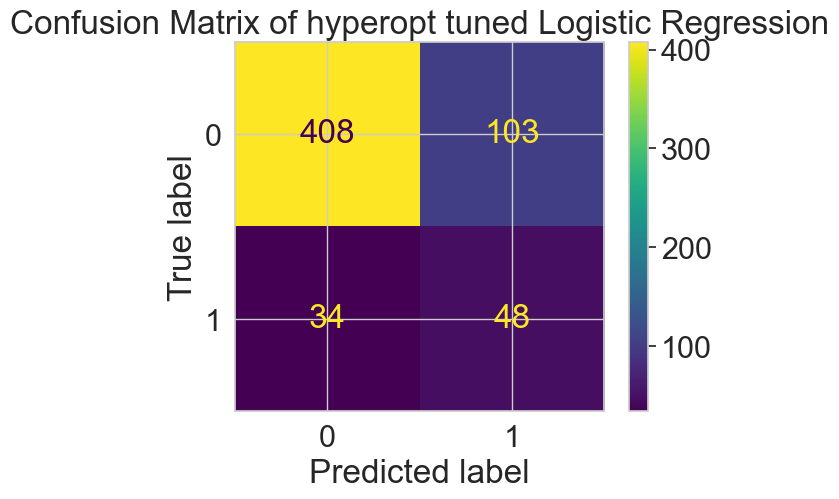

In [36]:
# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_model_hy_LR, x_test_scaled_final, y_test)
plt.title("Confusion Matrix of hyperopt tuned Logistic Regression")
plt.show()

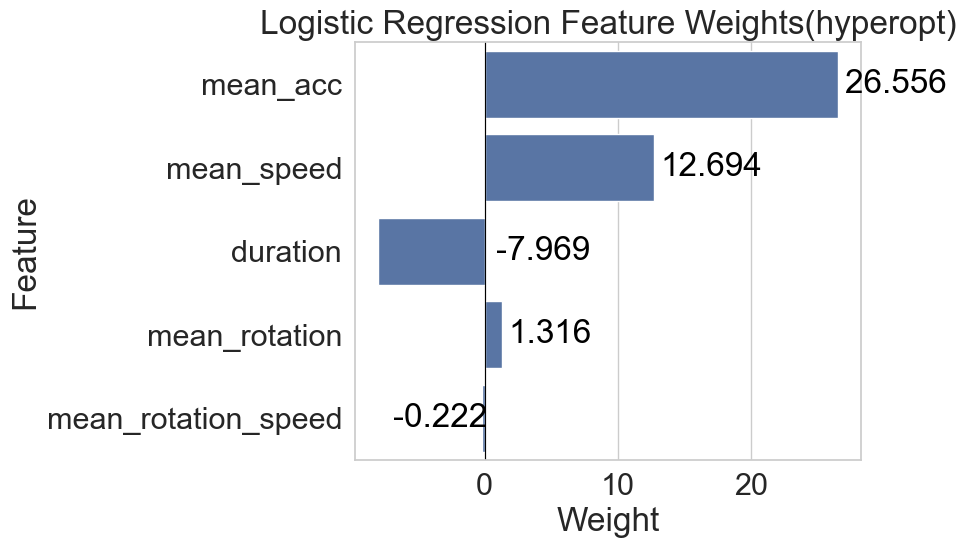

In [37]:
coefs = best_model_hy_LR.coef_[0]
# Create a DataFrame for better plotting
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight': coefs
}).sort_values(by='Weight', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Weight', y='Feature', data=coef_df)
plt.axvline(0, color='black', linewidth=0.8)

for i, (weight, feature) in enumerate(zip(coef_df['Weight'], coef_df['Feature'])):
    if weight > 0:
        plt.text(weight + 0.5, i, f"{weight:.3f}", va='center', ha='left', color='black')
    else:
        plt.text(weight + 2 * abs(weight), i, f"{weight:.3f}", va='center', ha='right', color='black')

plt.title('Logistic Regression Feature Weights(hyperopt)')
plt.tight_layout()
plt.show()


Tune a random forest model
- For random forest model, we want to tune:
    - 'n_estimators': 100-500(based on exploration), it defines the number of decision trees in the forest, increase the trees generally improves the performance but also increases the computational cost
    - 'max_depth': 5-15, a deeper tree contains more information but may lead to overfitting
    - 'max_features': 2 or 5, if all the features are used, the trees might be repeated
    - 'min_samples_split': 2-20, specify the minimum number of samples required to split an internal node, common defualt is 2
    - 'min_samples_leaf': 1-10,more leaves, more complex trees(more decisions to make)
    - 'bootstrap': yes or not
    - 'criterion':  ['gini', 'entropy'],
    - 'class_weight': [None, 'balanced']
  - (we started from these valus by reading online articles and recommendations given by chatGPT)
- Loss function:
  - - matthew correlation coefficient

In [38]:

def tune_random_forest(X_train, y_train, max_evals=500, random_state=random_state, scoring='matthews_corrcoef'):
    """
    Hyperparameter tuning for RandomForestClassifier using Hyperopt.

    Parameters
    ----------
    X_train : array-like, shape (n_samples, n_features)
        Training data.
    y_train : array-like, shape (n_samples,)
        Target values.
    max_evals : int, default=500
        Number of hyperopt evaluations.
    random_state : int, default=7, same as the splitting
        Random seed.
    scoring : matthews_correcoef

    Returns
    -------
    best_model : RandomForestClassifier
        RandomForestClassifier refit on the entire training data with best params.
    best_params : dict
        The best hyperparameter configuration found.
    trials : hyperopt.Trials
        The Trials object, containing the full search history.
    """

    # Options for categorical choices
    space_choices = {
        'max_depth': [None] + list(range(5, 15)),
        'max_features': [None, 'sqrt'],
        'bootstrap': [True, False],
        'criterion': ['gini', 'entropy'],
        'class_weight': [None, 'balanced']
    }

    # Search space
    param_space = {
        'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
        'max_depth': hp.choice('max_depth', space_choices['max_depth']),
        'max_features': hp.choice('max_features', space_choices['max_features']),
        'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
        'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
        'bootstrap': hp.choice('bootstrap', space_choices['bootstrap']),
        'criterion': hp.choice('criterion', space_choices['criterion']),
        'class_weight': hp.choice('class_weight', space_choices['class_weight'])
    }

    def objective(params):
        # Cast the integers back from floats
        params['n_estimators'] = int(params['n_estimators'])
        params['min_samples_split'] = int(params['min_samples_split'])
        params['min_samples_leaf'] = int(params['min_samples_leaf'])

        clf = RandomForestClassifier(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            max_features=params['max_features'],
            bootstrap=params['bootstrap'],
            criterion=params['criterion'],
            class_weight=params['class_weight'],
            random_state=random_state,
            n_jobs=-1
        )

        # We negate because Hyperopt minimizes the objective
        score = cross_val_score(clf, X_train, y_train, cv=5, scoring='matthews_corrcoef', n_jobs=-1).mean()
        return {'loss': -score, 'status': STATUS_OK}

    trials = Trials()
    best = fmin(
        fn=objective,
        space=param_space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials,
        rstate=np.random.default_rng(random_state)
    )

    # Decode choice indices to actual values
    best_params = {
        'n_estimators': int(best['n_estimators']),
        'max_depth': space_choices['max_depth'][best['max_depth']],
        'max_features': space_choices['max_features'][best['max_features']],
        'min_samples_split': int(best['min_samples_split']),
        'min_samples_leaf': int(best['min_samples_leaf']),
        'bootstrap': space_choices['bootstrap'][best['bootstrap']],
        'criterion': space_choices['criterion'][best['criterion']],
        'class_weight': space_choices['class_weight'][best['class_weight']],
        'random_state': random_state,
        'n_jobs': -1
    }


    # Refit on the full training data
    best_model = RandomForestClassifier(**best_params)
    best_model.fit(X_train, y_train)

    return best_model, best_params, trials


In [39]:
best_model_hy_RF, best_params_hy_RF, trials = tune_random_forest(x_train_scaled_final, y_train)

100%|██████████| 500/500 [21:41<00:00,  2.60s/trial, best loss: -0.4014418393158536] 


In [40]:
print(best_params_hy_RF)

{'n_estimators': 300, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 2, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'random_state': 7, 'n_jobs': -1}


In [41]:
# Predict and evaluate
y_pred = best_model_hy_RF.predict(x_test_scaled_final)
# Accuracy
acc_hy_RF = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc_hy_RF:.4f}")

# F1 Score
f1_hy_RF = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_hy_RF:.4f}")

#matthews_corrcoef
mcc_hy_RF = matthews_corrcoef(y_test, y_pred)
print(f"Matthews correcoefficient: {mcc_hy_RF: .4f}")

print("Classification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.8769
F1 Score: 0.4160
Matthews correcoefficient:  0.3778
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93       511
           1       0.60      0.32      0.42        82

    accuracy                           0.88       593
   macro avg       0.75      0.64      0.67       593
weighted avg       0.86      0.88      0.86       593



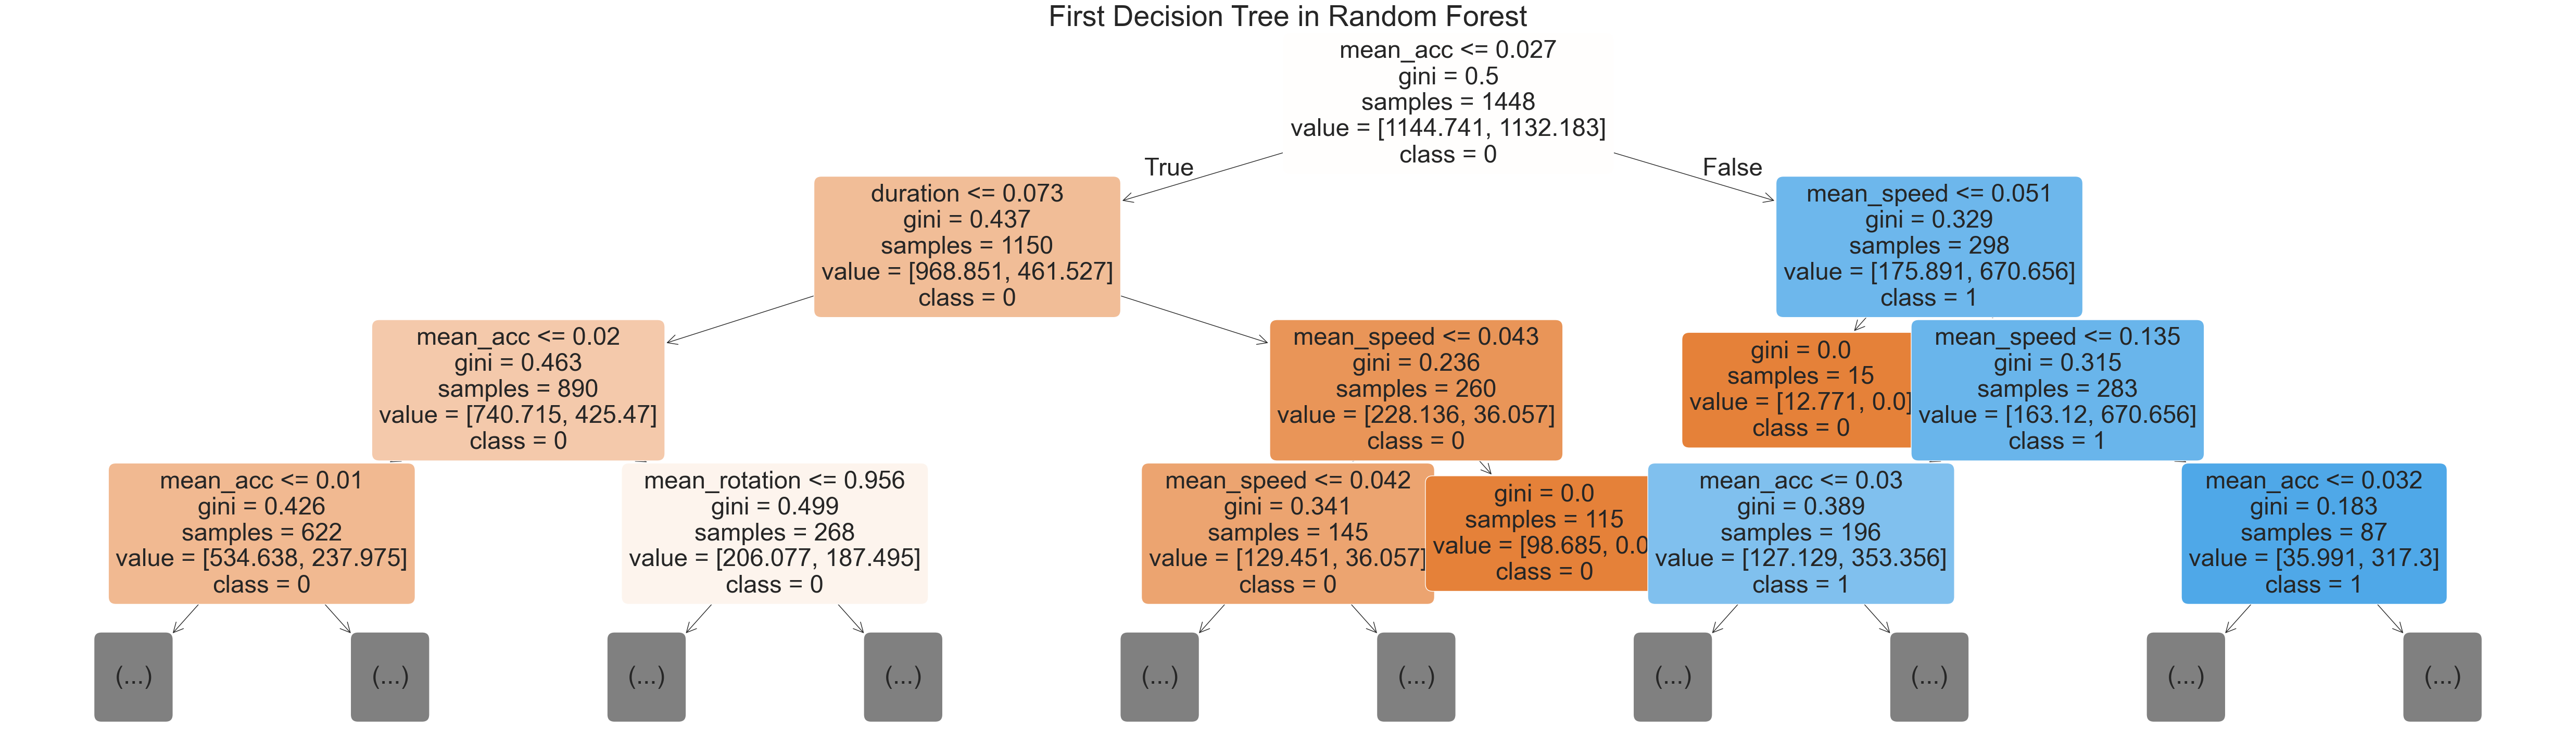

In [42]:

# Get the first decision tree from the forest
estimator = best_model_hy_RF.estimators_[0]

plt.figure(figsize=(50, 15))  # Increase overall size
plot_tree(estimator, 
          feature_names=x_train_scaled_final.columns, 
          class_names=[str(cls) for cls in best_model_hy_RF.classes_],
          filled=True, 
          rounded=True, 
          max_depth=3,          # Optional: limit depth for clarity
          fontsize=34)          # 👈 Make text much larger
plt.title("First Decision Tree in Random Forest", fontsize=40)
plt.tight_layout()
plt.show()

C:\Users\sky\AppData\Local\Temp\ipykernel_37800\3784403215.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df, x='Importance', y='Feature', palette="viridis")


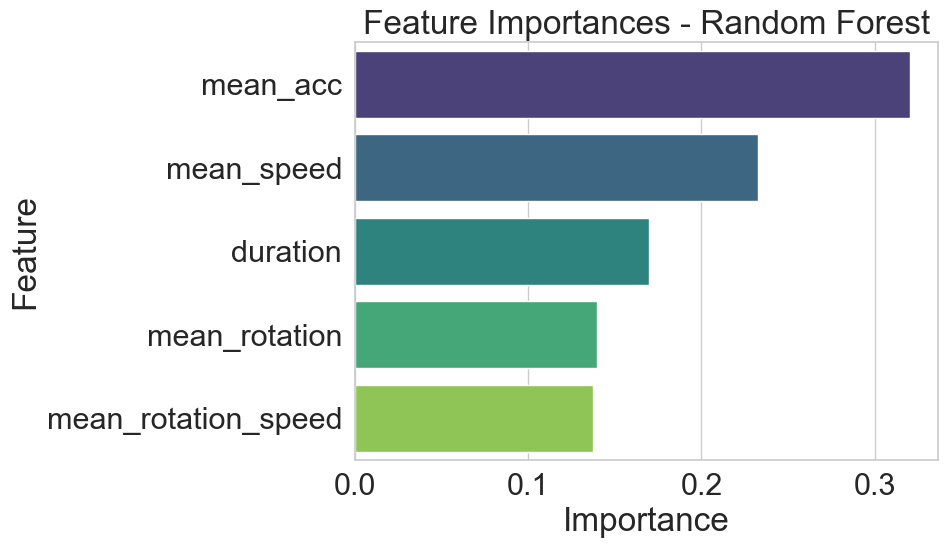

In [43]:

importances = best_model_hy_RF.feature_importances_
features = x_train_scaled_final.columns

feat_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_df = feat_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df, x='Importance', y='Feature', palette="viridis")
plt.title("Feature Importances - Random Forest")
plt.tight_layout()
plt.show()


### | Comparison among models

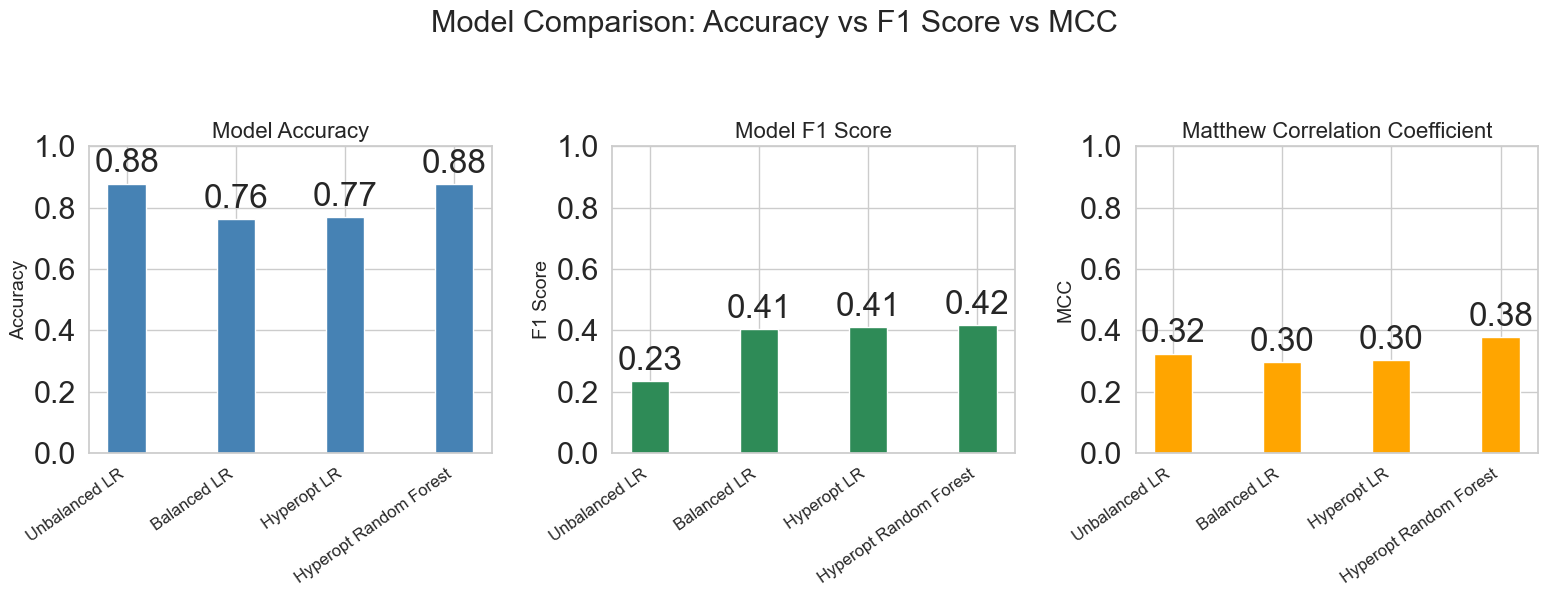

In [44]:
models = ['Unbalanced LR', 'Balanced LR', 'Hyperopt LR', 'Hyperopt Random Forest']
accuracy = [acc_unbalanced, acc_balanced, acc_hy_LR, acc_hy_RF]
f1_scores = [f1_unbalanced, f1_balanced, f1_hy_LR, f1_hy_RF]
mcc_scores = [mcc_unbalanced, mcc_balanced, mcc_hy_LR, mcc_hy_RF]  # use correct MCC variable names

x = np.arange(len(models))
width = 0.35

fig, axs = plt.subplots(1, 3, figsize=(16, 6))  # wider figure

# Accuracy plot
axs[0].bar(x, accuracy, width, color='steelblue')
axs[0].set_title('Model Accuracy', fontsize=16)
axs[0].set_xticks(x)
axs[0].set_xticklabels(models, rotation=35, ha='right', fontsize=12)
axs[0].set_ylim(0, 1)
axs[0].set_ylabel('Accuracy', fontsize=14)
axs[0].bar_label(axs[0].containers[0], fmt='%.2f', padding=3)

# F1 score plot
axs[1].bar(x, f1_scores, width, color='seagreen')
axs[1].set_title('Model F1 Score', fontsize=16)
axs[1].set_xticks(x)
axs[1].set_xticklabels(models, rotation=35, ha='right', fontsize=12)
axs[1].set_ylim(0, 1)
axs[1].set_ylabel('F1 Score', fontsize=14)
axs[1].bar_label(axs[1].containers[0], fmt='%.2f', padding=3)

# MCC plot
axs[2].bar(x, mcc_scores, width, color='orange')
axs[2].set_title('Matthew Correlation Coefficient', fontsize=16)
axs[2].set_xticks(x)
axs[2].set_xticklabels(models, rotation=35, ha='right', fontsize=12)
axs[2].set_ylim(0, 1)
axs[2].set_ylabel('MCC', fontsize=14)
axs[2].bar_label(axs[2].containers[0], fmt='%.2f', padding=3)  # fixed label to use axs[2]

plt.suptitle('Model Comparison: Accuracy vs F1 Score vs MCC', fontsize=22, y=1.02)

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)  # add space between plots

plt.show()

### Step 4: Interpreting the results

SHAP: SHapley Additive exPlanations, is a method that helps us understand how much each feature is helping or hurting the final prediction based on the game theory

### 1. Initialize the SHAP Explainer

In [45]:
#interpretation of the models
#explain the logistic regression
shap.initjs()
explainer_LR = shap.LinearExplainer(best_model_hy_LR, x_train_scaled_final,feature_perturbation = "interventional")
explainer_RF = shap.TreeExplainer(best_model_hy_RF,x_train_scaled_final,feature_perturbation="interventional")


c:\Users\sky\anaconda3\envs\waffles\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


### 2. Visualizing SHAP Values n Logistic Regression and Random Forest
- Summary plot:
  - x axis: represents the SHAP value, reflecting whether the feature is pushing the prediction higher or lower
  - each dot: represents a prediction, x value represnts the magnitude of the SHAP value for the prediction, the color gradient indicates the feature's value


(read more from https://medium.com/biased-algorithms/shap-values-for-random-forest-1150577563c9)

 99%|===================| 4549/4572 [02:22<00:00]        C:\Users\sky\AppData\Local\Temp\ipykernel_37800\3295940919.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_LR,x_train_scaled_final)


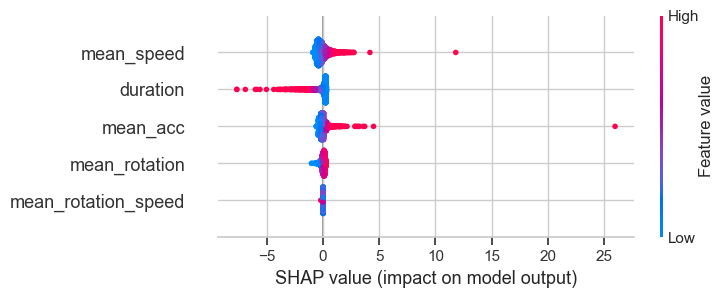

In [46]:
#calculate SHAP values
shap_values_LR = explainer_LR.shap_values(x_train_scaled_final)
shap_values_RF = explainer_RF.shap_values(x_train_scaled_final)

#summary plot: show overall feature importance and effects
shap.summary_plot(shap_values_LR,x_train_scaled_final)


C:\Users\sky\AppData\Local\Temp\ipykernel_37800\11905067.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_RF[:,:,1],x_train_scaled_final)


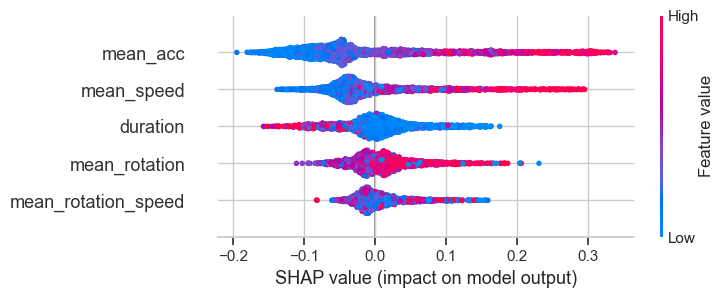

In [47]:
shap.summary_plot(shap_values_RF[:,:,1],x_train_scaled_final)

- Dependence plot: represents how a single feature's SHAP value changes as its value changes(plus the interative feature)
  - x axis: the value of the features
  - y axis: the SHAP value, 
  - Color coded by the interactive feature 

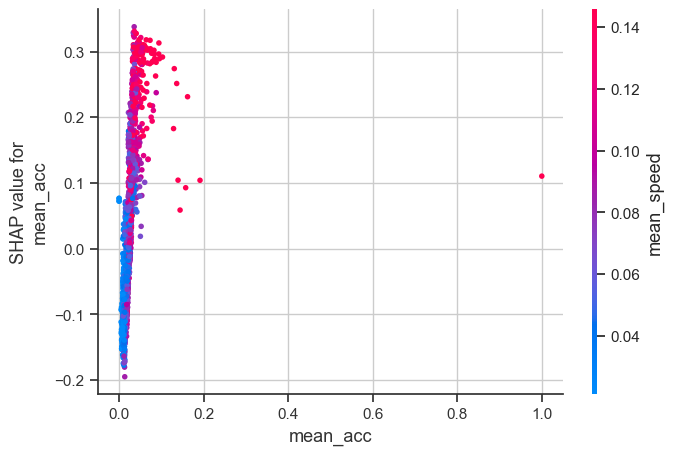

In [ ]:

# Then plot dependence for a specific feature
shap.dependence_plot('mean_acc', shap_values_RF[:,:,1], x_train_scaled_final,interaction_index='mean_speed')


1. From the summary plot, we can see most dots in the row of mean speed and mean acceleration of the investigation are on the positive side, and the higher value it is, the higher SHAP value it is, which improves the model prediction; Oppositely, we can see most dots in the row of the duration is at the negative side, and longer duration tends to negatively hurts the model prediction.
2. From the dependency plot, we can see the higher mean accerlation with higher speed of investigation has higher SHAP values(a higher chance of attack).

### Conclusion


1. The mean acceleration of an investigation bout of the resident might be the most informative feature for predicting whether the resident decides to attack, higher mean acceleration -> more likely to make an attack decision
2. The mean duration of an investigation bout of the resident mouse might be the least informative feature, and longer investigation -> less certain whether it'll attack

### Future Improvements

1. Handling class imbalance: in this notebool, we tried to address the imbalanced by assigning a higher weight to the minority class, which will cause a higher cost during training; other strategies include undersampling the majority class or oversampling the minority.
2. On the dataset:
    - Gender info is missing
    - All labels are from the resident’s perspective (when does it defend the intruder’s attack?)
3. Feature engineering: we started from 5 hand-crafted features based on our observations, including the duration, mean speed, mean investigations, mean body rotation angle, mean body rotation speed during an investigation bout; however, we might miss information generated by the original 7 keypoints, in the original CalMS21 dataset website, they also provide precomputed features based on TREBA(Trajectory Embedding for Behavior Analysis, https://github.com/neuroethology/TREBA), it'll be interesting to compare our model with fully precomputed features
datasets.



### Supplement Notes



- Matthews correlation coefficient: (TP*TN – FP*FN) / $\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}$, this metric is useful when the two classes are imbalanced.
- L1(Lasso) Regularization: L1 regularizatiion adds a penalty equivalent to the absolute sum of the coefficients, encourage sparsity
- L2(Ridge) Regularization: penalize square of coefficients

### References and recommendations for readings
1. Jennifer J. Sun, Ann Kennedy, Eric Zhan, David J. Anderson, Yisong Yue, Pietro Perona. Task Programming: Learning Data Efficient Behavior Representations. In Conference on Computer Vision and Pattern Recognition (CVPR), 2021.
2. Cristina Segalin, Jalani Williams, Tomomi Karigo, May Hui, Moriel Zelikowsky, Jennifer J Sun, Pietro Perona, David J Anderson, Ann Kennedy (2021) The Mouse Action Recognition System (MARS) software pipeline for automated analysis of social behaviors in mice eLife 10:e63720 https://doi.org/




### Ackelowdgement
1. Pod TA: Nikolai Safronov
2. Project TAs: Cocoa Kaushal and Evgenii O. Tretiakov
3. We are inspired by many previous NMA project, and we want to say 'thank you' to them:
   1. Resident-Intruder Paradigm (CalMS21 Dataset) By: Patrize Aguilar, Zaeem Hadi, Eslam Radwan, Monolophosaurus/Bagaceratops Pod Neurosaurus.
   2. Predicting mouse behaviour using Long Short-Term Memory (LSTM) model, By: Arun Kumar, Eric S Minj, Lakshana Balaji, Mukta Londhe, Nisha Thapa, Roberto Park, Taewoo Kim, Wenqi Wang, Yuke Wang, Zelin Zhao
   3. When mice attack: Predicting aggressive behaviour through kinematic features in the resident-intruder assay, Group: Cal-ATTACK
   4. Vishawanian Process(Group name)
   5. and more